In [1]:
import matplotlib.pyplot as plt
import requests
import json
import numpy as np
import pandas as pd

In [2]:
from src.paychex_ml.external_data import get_bls_data
from src.paychex_ml.external_data import get_census_data
from src.paychex_ml.external_data import get_external_data
from src.paychex_ml.external_data import get_fred_data

# Data

## BLS

In [4]:
seriesid = ["LNS14000000", "CEU0000000001", "CES0000000001"]

In [5]:
df = get_bls_data(seriesid)

Processing:  LNS14000000
Processing:  CEU0000000001
Processing:  CES0000000001


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 20220301 to 20150101
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UnemploymentRate  87 non-null     float64
 1   NFPayrolls_nsa    87 non-null     float64
 2   NFPayrolls_sa     87 non-null     float64
dtypes: float64(3)
memory usage: 2.7+ KB


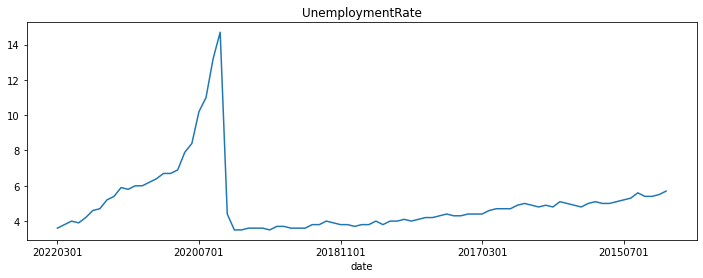

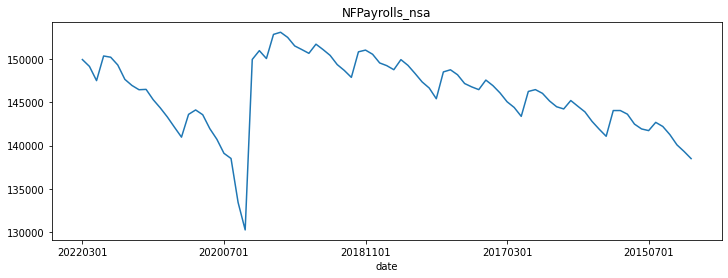

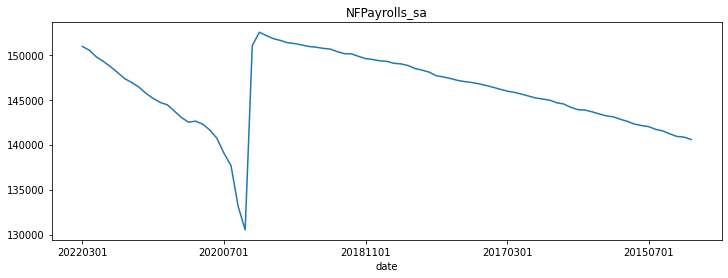

In [9]:
for c in df.columns:
    fig, ax = plt.subplots(figsize=(12,4))
    df[c].plot(ax = ax)
    plt.title(c)

## Census

In [10]:
df = get_census_data()

Reading census data


In [11]:
df

seasonally_adj,BusinessApplications_nsa,BusinessApplications_sa
date,,
20150101,258765,256949
20150201,244207,229473
20150301,249226,229317
20150401,296477,231164
20150501,212198,224660
...,...,...
20211101,333958,431017
20211201,372825,418884
20220101,445536,428443


## FRED

In [3]:
series_dict = {
    'Nation Income & Expenditures': ['GDPC1', 'GDPPOT', 'W875RX1', 'PCEC96', 'PSAVERT', 'FYFR', 'FYONET', 'FYFSD','GFDEBTN'],
    'Pop Employment Labor': ['PAYEMS', 'UNRATE', 'ICSA', 'UEMPMEAN', 'JTSJOL', 'AWHMAN', 'AHETPI', 'OPHNFB', 'POP', 'CLF16OV',
                             'CIVPART'],
    'Prod & Bus Act': ['INDPRO', 'TCU', 'BUSINV', 'RRSFS', 'ALTSALES', 'DGORDER', 'BUSLOANS', 'TOTALSL', 'CP', 'HOUST', 'PERMIT',
                       'UNDCONTSA'],
    'Prices': ['CPIAUCSL', 'PCEPI', 'PCEPILFE', 'GDPDEF', 'PPIFIS', 'WPSFD49207', 'WPSFD4131', 'WPSID62', 'USSTHPI', 'SPCS20RSA',
               'DCOILWTICO', 'GASREGW', 'MHHNGSP'],
    'Money Bank Finance': ['BOGMBASE', 'M1SL', 'M2SL', 'SP500', 'DJIA', 'WILL5000IND', 'VIXCLS', 'STLFSI2', 'BAMLCC0A2AATRIV', 'FF', 'WGS3MO', 'WGS1YR', 'WGS5YR', 'WFII5', 'WGS10YR', 'WFII10', 'WAAA', 'WBAA', 'MORTGAGE15US', 'MORTGAGE30US', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS']

}

In [4]:
df = get_fred_data(series_dict)

Loading category:  Nation Income & Expenditures
Loading series:  GDPC1
Loading series:  GDPPOT
Loading series:  W875RX1
Loading series:  PCEC96
Loading series:  PSAVERT
Loading series:  FYFR
Loading series:  FYONET
Loading series:  FYFSD
Loading series:  GFDEBTN
Loading category:  Pop Employment Labor
Loading series:  PAYEMS
Loading series:  UNRATE
Loading series:  ICSA
Loading series:  UEMPMEAN
Loading series:  JTSJOL
Loading series:  AWHMAN
Loading series:  AHETPI
Loading series:  OPHNFB
Loading series:  POP
Loading series:  CLF16OV
Loading series:  CIVPART
Loading category:  Prod & Bus Act
Loading series:  INDPRO
Loading series:  TCU
Loading series:  BUSINV
Loading series:  RRSFS
Loading series:  ALTSALES
Loading series:  DGORDER
Loading series:  BUSLOANS
Loading series:  TOTALSL
Loading series:  CP
Loading series:  HOUST
Loading series:  PERMIT
Loading series:  UNDCONTSA
Loading category:  Prices
Loading series:  CPIAUCSL
Loading series:  PCEPI
Loading series:  PCEPILFE
Loading ser

In [5]:
df

Nation Income & Expenditures                                          \
                                GDPC1        GDPPOT  W875RX1   PCEC96 PSAVERT   
date                                                                            
20100101                 15456.059000  16173.804340  10490.7  10547.0     5.9   
20100201                 15507.577211  16192.208007  10487.0  10586.5     5.6   
20100301                 15554.109789  16208.830673  10529.1  10637.1     5.6   
20100401                 15605.628000  16227.234340  10638.7  10658.8     6.2   
20100501                 15645.404044  16245.702080  10740.6  10685.3     6.7   
...                               ...           ...      ...      ...     ...   
20310601                          NaN  23688.814835      NaN      NaN     NaN   
20310701                          NaN  23721.650000      NaN      NaN     NaN   
20310801                          NaN  23755.231087      NaN      NaN     NaN   
20310901                          NaN  23788.812174      NaN      NaN     NaN   
20311001                          NaN  23821.310000      NaN      NaN     NaN   

                                                                  \
                  FYFR        FYONET         FYFSD       GFDEBTN   
date                                                               
20100101  2.124281e+06  3.497422e+06 -1.373142e+06  1.277312e+07   
20100201  2.129183e+06  3.492276e+06 -1.363093e+06  1.292078e+07   
20100301  2.133610e+06  3.487627e+06 -1.354017e+06  1.305414e+07   
20100401  2.138512e+06  3.482480e+06 -1.343968e+06  1.320179e+07   
20100501  2.143256e+06  3.477500e+06 -1.334244e+06  1.332042e+07   
...                ...           ...           ...           ...   
20310601           NaN           NaN           NaN           NaN   
20310701           NaN           NaN           NaN           NaN   
20310801           NaN           NaN           NaN           NaN   
20310901           NaN           NaN           NaN           NaN   
20311001           NaN           NaN           NaN           NaN   

         Pop Employment Labor  ... Money Bank Finance                          \
                       PAYEMS  ...              WFII5 WGS10YR  WFII10    WAAA   
date                           ...                                              
20100101             129790.0  ...             0.4380   3.750  1.3940  5.2760   
20100201             129698.0  ...             0.4175   3.695  1.4225  5.3500   
20100301             129879.0  ...             0.5325   3.705  1.4900  5.2575   
20100401             130110.0  ...             0.6360   3.850  1.5160  5.2940   
20100501             130650.0  ...             0.4100   3.420  1.3075  4.9625   
...                       ...  ...                ...     ...     ...     ...   
20310601                  NaN  ...                NaN     NaN     NaN     NaN   
20310701                  NaN  ...                NaN     NaN     NaN     NaN   
20310801                  NaN  ...                NaN     NaN     NaN     NaN   
20310901                  NaN  ...                NaN     NaN     NaN     NaN   
20311001                  NaN  ...                NaN     NaN     NaN     NaN   

                                                                          
            WBAA MORTGAGE15US MORTGAGE30US   DEXUSEU   DEXCHUS   DEXCAUS  
date                                                                      
20100101  6.2780       4.4350       5.0300  1.426574  6.826916  1.043811  
20100201  6.3475       4.3675       4.9900  1.367995  6.828463  1.057211  
20100301  6.2625       4.3300       4.9675  1.357004  6.826183  1.022900  
20100401  6.2660       4.4180       5.0980  1.341682  6.825550  1.005209  
20100501  6.0500       4.2775       4.8875  1.256315  6.827450  1.040280  
...          ...          ...          ...       ...       ...       ...  
20310601     NaN          NaN          NaN       NaN       NaN       NaN  
20310701     NaN          NaN       

#### Dictionary

In [274]:
dictionary = []
for k in series_dict:
    print(k)
    for s in series_dict[k]:
        url = 'https://api.stlouisfed.org/fred/series?series_id={}&api_key={}&file_type=json'\
            .format(s,"2f07bf8c1db37581bdb4874f8fa68418")
        p = requests.get(url)
        json_response = json.loads(p.text)
        df = pd.DataFrame(json_response['seriess'])
        dictionary.append(df)
pd.concat(dictionary)#.to_excel('DictionaryFRED.xlsx')

Nation Income & Expenditures
GDPC1
GDPPOT
W875RX1
PCEC96
PSAVERT
FYFR
FYONET
FYFSD
GFDEBTN
Pop Employment Labor
PAYEMS
UNRATE
ICSA
UEMPMEAN
JTSJOL
AWHMAN
AHETPI
OPHNFB
POP
CLF16OV
CIVPART
Prod & Bus Act
INDPRO
TCU
BUSINV
RRSFS
ALTSALES
DGORDER
BUSLOANS
TOTALSL
CP
HOUST
PERMIT
UNDCONTSA
Prices
CPIAUCSL
PCEPI
PCEPILFE
GDPDEF
PPIFIS
WPSFD49207
WPSFD4131
WPSID62
USSTHPI
SPCS20RSA
DCOILWTICO
GASREGW
MHHNGSP
Money Bank Finance
BOGMBASE
M1SL
M2SL
SP500
DJIA
WILL5000IND
VIXCLS
STLFSI2
BAMLCC0A2AATRIV
FF
WGS3MO
WGS1YR
WGS5YR
WFII5
WGS10YR
WFII10
WAAA
WBAA
MORTGAGE15US
MORTGAGE30US
DEXUSEU
DEXCHUS
DEXCAUS


# Correlations

In [19]:
from io import BytesIO
from azure.storage.blob import BlobServiceClient
from src.paychex_ml.utils import load_credentials

In [20]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [9]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

In [22]:
# Download file
file = 'table_predictable.csv'
stream_downloader = container_client.download_blob(file)
stream = BytesIO()
stream_downloader.readinto(stream)
stream.seek(0)
df = pd.read_csv(stream)

In [23]:
df

,Unnamed: 0,Calendar Date,Scenario,Version,Fiscal Year,Period,File,Product,Account,Detail,Item,Value
0,0,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,401(K) PLANS,5765 SEBS,FEE REVENUE - NA - RW,401K Fee Revenue,0.0
1,1,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,401(K) PLANS,5600 401K ADMINISTRATION,FEE REVENUE - NA - RW,401K Fee Revenue,927785.0
2,2,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,401K NSI EXPORT,5600 401K ADMINISTRATION,FEE REVENUE - NA - RW,401K Fee Revenue,-460.0
3,3,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,RETIREMENT PLANS,5600 401K ADMINISTRATION,FEE REVENUE - NA - RW,401K Fee Revenue,0.0
4,4,20140601,Actual,Final Revised,FY15,1,401kRevenueDetail.txt,401(K) PLANS,5745 EPLAN,FEE REVENUE - NA - RW,401K Fee Revenue,15943.0
...,...,...,...,...,...,...,...,...,...,...,...,...
592867,592867,20220501,Forecast,8+4,FY22,12,SurePayollRevenue.txt,PREMIER HRS,1501 SP Direct GB,SALES DISCOUNTS - CONTRACT PLAN - RW,SurePayroll.,0.0
592868,592868,20220501,Forecast,8+4,FY22,12,SurePayollRevenue.txt,PREMIER HRS,1506 SP BOP PARTNER,FEE REVENUE - CONTRACT PLAN - RW,SurePayroll.,0.0
592869,592869,20220501,Forecast,8+4,FY22,12,SurePayollRevenue.txt,PREMIER HRS,1506 SP BOP PARTNER,MAINTENANCE REVENUE - NA - RW,SurePayroll.,0.0
592870,592870,20220501,Forecast,8+4,FY22,12,SurePayollRevenue.txt,PREMIER HRS,1506 SP BOP PARTNER,SALES DISCOUNTS - NA - RW,SurePayroll.,0.0
